## SVM

In [17]:
import torch
import keras
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from tqdm import tqdm

In [18]:
(x_train, y_train), (x_test, y_test)= keras.datasets.mnist.load_data()

Using MPS device
Fold 1/3


Epoch 1/1: 100%|██████████| 1250/1250 [00:04<00:00, 273.36it/s]


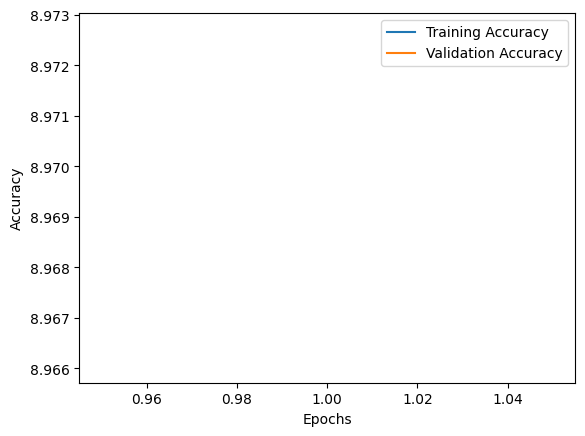

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')
tensor([0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')
tensor([0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0,
        0, 0, 0, 

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass-multioutput targets

In [36]:
n_epochs = 1

# Assuming you have your data loaded as x_train_svm and y_train_svm (NumPy arrays)

# Convert data to PyTorch tensors
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).long()  # LongTensor for class labels

# Check for MPS device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS device not found, using CPU")

# Define your SVM model in PyTorch
class SVM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SVM, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

# Instantiate the model
input_size = x_train.shape[1]  # Number of features
num_classes = len(np.unique(y_train))  # Number of classes
svm_model = SVM(input_size, num_classes)

# Move model to the MPS device
svm_model.to(device)
y_train_tensor = torch.nn.functional.one_hot(y_train_tensor, num_classes=num_classes).float().to(device) 

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.SGD(svm_model.parameters(), lr=0.01)

# Perform k-fold cross-validation (e.g., k=3)
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Shuffle data for better generalization
cross_svm_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train_tensor)):
    print(f'Fold {fold + 1}/{k}')

    # Create data loaders for training and validation sets
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)
    train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, sampler=val_sampler)

    # Training loop
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        svm_model.train()
        correct_train = 0
        total_train = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{n_epochs}'):
            # Move data and target to the MPS device
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = svm_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        svm_model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data, target in val_loader:
                # Move data and target to the MPS device
                data = data.to(device)
                target = target.to(device)
                output = svm_model(data)
                _, predicted = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

    plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, n_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Validation loop
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in val_loader:
            # Move data and target to the MPS device
            data = data.to(device)
            target = target.to(device)
            output = svm_model(data)
            _, predicted = torch.max(output.data, 1)
            predicted_labels = torch.argmax(predicted, dim=1)
            print(predicted_labels)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total

    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    print(f'Fold precision: {precision}')
    print(f'Fold recall: {recall}')
    print(f'Fold F1 score: {f1}')
    print(f'Fold accuracy: {accuracy}')
    cross_svm_scores.append(accuracy)

# Print average accuracy across all folds
print(f'SVM cross-validation scores: {cross_svm_scores}')
print(f'Average accuracy: {torch.mean(torch.tensor(cross_svm_scores))}')